# 작업 2유형 (파이썬)

[![Hits](https://hits.seeyoufarm.com/api/count/incr/badge.svg?url=https%3A%2F%2Fwww.datamanim.com%2Fdataset%2F03_dataq%2Ftypetwo.html&count_bg=%238921C0&title_bg=%23555555&icon=&icon_color=%23E7E7E7&title=hits&edge_flat=false)](https://hits.seeyoufarm.com)

### 홈페이지 서버가 자주 터져요 ㅠ 광고 클릭 한번이 유지보수에 큰 도움이 됩니다,,,

```{admonition} 참고
**모든 문제의 y_test값은 해당 url에서 y_test로 불러와 확인가능합니다. 실제로 제출을 위해 만든 데이터의 예측 점수를 확인해보세요**
```  

## 분류

### 분류 모델을 위한 공통 함수

In [27]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [28]:
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 25
pd.options.display.float_format = '{:,.4f}'.format

In [53]:
def get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=True):
    A1 = model.score(xtrain, ytrain)
    A2 = model.score(xtest, ytest)
    
    if is_binary_model:
        ypred = model.predict_proba(xtest)[:,1]
        B = roc_auc_score(ytest, ypred)
        
        scores = pd.Series([A1, A2, B], index='Train_Accuracy Test_Accuracy ROC_AUC'.split())
    else: 
        ypred = model.predict(xtest)
        C1 = accuracy_score(ytest, ypred)
        C2 = precision_score(ytest, ypred, average='weighted')
        C3 = recall_score(ytest, ypred, average='weighted')
        C4 = f1_score(ytest, ypred, average='weighted')
        
        scores = pd.Series([A1, A2, C1, C2, C3, C4], index='Train_Accuracy Test_Accuracy Accuracy Precision Recall F1'.split())
    
    return scores    

In [30]:
def compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=True):
    result = pd.DataFrame()
    
    if is_binary_model:
        model = LogisticRegression(max_iter=5000, random_state=1234).fit(xtrain, ytrain)
        result[f'{model.__class__.__name__}'] = \
            get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)
        
        # for i in range(100, 901, 100):
        #     model = LogisticRegression(max_iter=i, random_state=1234).fit(xtrain, ytrain)
        #     result[f'{model.__class__.__name__}_{i}'] = \
        #         get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)
        
    model = KNeighborsClassifier().fit(xtrain, ytrain)
    result[f'{model.__class__.__name__}'] = \
        get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)
    
    # for n in range(1,10):
    #     model = KNeighborsClassifier(n_neighbors=n).fit(xtrain, ytrain)
    #     result[f'{model.__class__.__name__}_{n}'] = \
    #         get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)        

    model = DecisionTreeClassifier(random_state=1234).fit(xtrain, ytrain)
    result[f'{model.__class__.__name__}'] = \
        get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)

    model = RandomForestClassifier(random_state=1234).fit(xtrain, ytrain)
    result[f'{model.__class__.__name__}'] = \
        get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)
    
    # for d in range(1,10):
    #     model = RandomForestClassifier(max_depth=d, random_state=1234).fit(xtrain, ytrain)
    #     result[f'{model.__class__.__name__}_{d}'] = \
    #         get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)    
    
    # params = {'n_estimators': range(100, 501, 100), \
    #           'criterion': ['gini', 'entropy'], \
    #           'max_depth': range(1,9) }
    # model = GridSearchCV(RandomForestClassifier(random_state=1234), params).fit(xtrain, ytrain).best_estimator_
    # print(model.get_params())
    # result[f'{model.__class__.__name__}'] = \
    #     get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)   
    
    model = XGBClassifier().fit(xtrain, ytrain)
    result[f'{model.__class__.__name__}'] = \
        get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=is_binary_model)

    result = result.T
    result.insert(loc=2, column='DIFF', value=(result['Train_Accuracy'] - result['Test_Accuracy']).abs())
    
    return result

In [31]:
def get_classification_model_data(dfX, Y, train_size, x_features, y_feature, is_normalized=False):
    X_temp = dfX[x_features]
    
    if is_normalized:
        X_temp = MinMaxScaler().fit_transform(X_temp)
    
    XF = X_temp[:train_size]
    YF = Y[y_feature]
    X_submissionF = X_temp[train_size:]
    
    return XF, X_submissionF, YF

### 서비스 이탈예측 데이터

```{attention}  
데이터 설명 :  고객의 신상정보 데이터를 통한 회사 서비스 이탈 예측 (종속변수 : Exited)     
x_train :  https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_train.csv     
y_train :  https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_train.csv     
x_test :  https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_test.csv          
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_test.csv      
데이터 출처 : https://www.kaggle.com/shubh0799/churn-modelling 에서 변형   
```  

```{admonition} 캐글 공유 코드 저장소 
**본인만의 코드를 작성하고 upvote를 받아 broze medal을 획득 해보세요**
[캐글 노트북 링크](https://www.kaggle.com/datasets/kukuroo3/churn-model-data-set-competition-form/code)
```

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_test.csv")


display(x_train.head())
display(y_train.head())

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15799217,Zetticci,791,Germany,Female,35,7,52436.20,1,1,0,161051.75
1,15748986,Bischof,705,Germany,Male,42,8,166685.92,2,1,1,55313.51
2,15722004,Hsiung,543,France,Female,31,4,138317.94,1,0,0,61843.73
3,15780966,Pritchard,709,France,Female,32,2,0.00,2,0,0,109681.29
4,15636731,Ts'ai,714,Germany,Female,36,1,101609.01,2,1,1,447.73


,CustomerId,Exited
0,15799217,0
1,15748986,0
2,15722004,0
3,15780966,0
4,15636731,0


#### EDA

In [15]:
X = x_train.copy()
X_submission = x_test.copy()
Y = y_train.copy()

In [16]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [17]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerId  6499 non-null   int64
 1   Exited      6499 non-null   int64
dtypes: int64(2)
memory usage: 101.7 KB


In [18]:
dfXY = pd.merge(dfX, Y, on='CustomerId')
dfXY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       6499 non-null   int64  
 1   Surname          6499 non-null   object 
 2   CreditScore      6499 non-null   int64  
 3   Geography        6499 non-null   object 
 4   Gender           6499 non-null   object 
 5   Age              6499 non-null   int64  
 6   Tenure           6499 non-null   int64  
 7   Balance          6499 non-null   float64
 8   NumOfProducts    6499 non-null   int64  
 9   HasCrCard        6499 non-null   int64  
 10  IsActiveMember   6499 non-null   int64  
 11  EstimatedSalary  6499 non-null   float64
 12  Exited           6499 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 660.2+ KB


In [19]:
dfXY.head(2)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15799217,Zetticci,791,Germany,Female,35,7,52436.20,1,1,0,161051.75,0
1,15748986,Bischof,705,Germany,Male,42,8,166685.92,2,1,1,55313.51,0


In [21]:
dfXY.corr(numeric_only=True)['Exited']
# Age, Balance, IsActiveMember > 10% 이상

CustomerId        -0.003726
CreditScore       -0.031130
Age                0.290102
Tenure            -0.003436
Balance            0.110606
NumOfProducts     -0.061488
HasCrCard         -0.008876
IsActiveMember    -0.154442
EstimatedSalary    0.008826
Exited             1.000000
Name: Exited, dtype: float64

In [24]:
for feature in dfXY.select_dtypes(include='object').columns:
    print(f'{feature}')
    print(dfXY.groupby('Exited')[feature].value_counts(normalize=True))
    print('-' * 30)

Surname
Exited  Surname      
0       Brown            0.003671
        Scott            0.003478
        Yeh              0.002899
        Maclean          0.002899
        Genovese         0.002899
                           ...   
1       Mazzanti         0.000755
        Keeley           0.000755
        Iweobiegbunam    0.000755
        Jackson          0.000755
        Lawson           0.000755
Name: proportion, Length: 2919, dtype: float64
------------------------------
Geography
Exited  Geography
0       France       0.523865
        Spain        0.261256
        Germany      0.214879
1       Germany      0.406344
        France       0.389728
        Spain        0.203927
Name: proportion, dtype: float64
------------------------------
Gender
Exited  Gender
0       Male      0.561546
        Female    0.414686
         male     0.013140
        female    0.010628
1       Female    0.540030
        Male      0.437311
        female    0.013595
         male     0.009063
Name: pr

#### 데이터 전처리

In [25]:
dfX.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [46]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  int32  
 3   Gender           10000 non-null  int8   
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int32(1), int64(7), int8(1)
memory usage: 752.1 KB


In [27]:
dfX.drop(columns='Surname', inplace=True)

In [30]:
dfX['Geography'] = LabelEncoder().fit_transform(dfX['Geography'])

In [45]:
dfX['Gender'] = dfX['Gender'].str.strip().str.lower().astype('category').cat.codes

#### 모델링

In [48]:
x_features = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure','Balance', \
              'NumOfProducts', 'HasCrCard', 'IsActiveMember','EstimatedSalary']
y_feature = 'Exited'

In [49]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

print([x.shape for x in [X, X_submission, Y]])
print([x.shape for x in [XF, X_submissionF, YF]])

[(6499, 12), (3501, 12), (6499, 2)]
[(6499, 10), (3501, 10), (6499,)]


In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=1234, stratify=YF)

print([x.shape for x in [xtrain, xtest, ytrain, ytest]])

[(4549, 10), (1950, 10), (4549,), (1950,)]


In [56]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=True)

In [59]:
result.sort_values(['Test_Accuracy', 'DIFF', 'ROC_AUC'], ascending=[False, True, False])

,Train_Accuray,Test_Accuracy,DIFF,ROC_AUC
RandomForestClassifier,0.999780,0.864615,0.135165,0.855645
XGBClassifier,0.980875,0.851795,0.129080,0.847932
LogisticRegression,0.791603,0.790256,0.001346,0.667115
DecisionTreeClassifier,1.000000,0.778462,0.221538,0.678104
KNeighborsClassifier,0.813585,0.765128,0.048457,0.539377


In [60]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=False)

In [62]:
result.sort_values(['Test_Accuracy', 'DIFF', 'Precision'], ascending=[False, True, False])

,Train_Accuray,Test_Accuracy,DIFF,Accuracy,Precision,Recall,F1
RandomForestClassifier,0.999780,0.864615,0.135165,0.864615,0.785408,0.460957,0.580952
XGBClassifier,0.980875,0.851795,0.129080,0.851795,0.695652,0.483627,0.570579
DecisionTreeClassifier,1.000000,0.778462,0.221538,0.778462,0.460137,0.508816,0.483254
KNeighborsClassifier,0.813585,0.765128,0.048457,0.765128,0.274074,0.093199,0.139098


In [64]:
model = RandomForestClassifier(random_state=1234).fit(xtrain, ytrain)
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=False))

Train_Accuray    0.999780
Test_Accuracy    0.864615
Accuracy         0.864615
Precision        0.785408
Recall           0.460957
F1               0.580952
dtype: float64


In [71]:
Ypred = model.predict(X_submissionF)

In [72]:
submission = pd.DataFrame({'CustomerId': X_submission['CustomerId'], \
                           'Exited': Ypred})
submission.to_csv('./submission.csv', index=False)

#### 실제 결과와 비교 (Precision Score)

In [226]:
y_true = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_test.csv")
y_pred = pd.read_csv('./submission.csv')

display(y_true.head(2))
display(y_pred.head(2))

,CustomerId,Exited
0,15601012,1
1,15734762,1


,CustomerId,Exited
0,15601012,1
1,15734762,1


In [100]:
print(f"정확도   : {accuracy_score(y_true['Exited'], y_pred['Exited']):,.4f}")
print(f"정확도   : {precision_score(y_true['Exited'], y_pred['Exited']):,.4f}")
print(f"재현율   : {recall_score(y_true['Exited'], y_pred['Exited']):,.4f}")
print(f"F1      : {f1_score(y_true['Exited'], y_pred['Exited']):,.4f}")

정확도   : 0.8618
정확도   : 0.7870
재현율   : 0.4404
F1      : 0.5647


### 이직여부 판단 데이터

```{attention}  
데이터 설명 : 이직여부 판단 데이터 (target: 1: 이직 , 0 : 이직 x)    
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/X_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/X_test.csv    
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/y_test.csv      
데이터 출처 :https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists (참고, 데이터 수정)   
```  

```{admonition} 캐글 공유 코드 저장소 
**본인만의 코드를 작성하고 upvote를 받아 broze medal을 획득 해보세요**
[캐글 노트북 링크](https://www.kaggle.com/datasets/kukuroo3/hr-data-predict-change-jobscompetition-form/code)
```

In [262]:
import pandas as pd
#데이터 로드
X = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/X_train.csv")
Y = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/y_train.csv")
X_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/X_test.csv")
Y_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/HRdata/y_test.csv")

display(x_train.head())
display(y_train.head())

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,25298,city_138,0.836,Male,No relevent experience,Full time course,High School,NaN,5,100-500,Pvt Ltd,1,45
1,4241,city_160,0.920,Male,No relevent experience,Full time course,High School,NaN,5,NaN,NaN,1,17
2,24086,city_57,0.866,Male,No relevent experience,no_enrollment,Graduate,STEM,10,NaN,NaN,1,50
3,26773,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,>4,135
4,32325,city_143,0.740,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,17


,enrollee_id,target
0,25298,0.0
1,4241,1.0
2,24086,0.0
3,26773,0.0
4,32325,1.0


#### EDA

In [228]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12452 entries, 0 to 12451
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             12452 non-null  int64  
 1   city                    12452 non-null  object 
 2   city_development_index  12452 non-null  float64
 3   gender                  9535 non-null   object 
 4   relevent_experience     12452 non-null  object 
 5   enrolled_university     12195 non-null  object 
 6   education_level         12137 non-null  object 
 7   major_discipline        10586 non-null  object 
 8   experience              12415 non-null  object 
 9   company_size            8600 non-null   object 
 10  company_type            8471 non-null   object 
 11  last_new_job            12179 non-null  object 
 12  training_hours          12452 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.2+ MB


In [229]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12452 entries, 0 to 12451
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   enrollee_id  12452 non-null  int64  
 1   target       12452 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 194.7 KB


In [230]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.9+ MB


In [231]:
dfX.head(2)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,25298,city_138,0.836,Male,No relevent experience,Full time course,High School,NaN,5,100-500,Pvt Ltd,1,45
1,4241,city_160,0.920,Male,No relevent experience,Full time course,High School,NaN,5,NaN,NaN,1,17


In [232]:
Y.head(2)

,enrollee_id,target
0,25298,0.0
1,4241,1.0


In [233]:
dfXY = pd.merge(dfX, Y, on='enrollee_id')

In [234]:
dfXY.corr(numeric_only=True)

,enrollee_id,city_development_index,training_hours,target
enrollee_id,1.000000,-0.029636,0.003429,0.042283
city_development_index,-0.029636,1.000000,-0.003967,-0.352236
training_hours,0.003429,-0.003967,1.000000,-0.013660
target,0.042283,-0.352236,-0.013660,1.000000


In [235]:
for target in dfXY.columns[dfXY.isna().sum() > 0]:
    print(dfXY.groupby('target')[target].value_counts(normalize=True))
    print('-' * 30)

target  gender
0.0     Male      0.904568
        Female    0.081838
        Other     0.013594
1.0     Male      0.890776
        Female    0.094539
        Other     0.014686
Name: proportion, dtype: float64
------------------------------
target  enrolled_university
0.0     no_enrollment          0.771335
        Full time course       0.164687
        Part time course       0.063978
1.0     no_enrollment          0.628477
        Full time course       0.304636
        Part time course       0.066887
Name: proportion, dtype: float64
------------------------------
target  education_level
0.0     Graduate           0.595544
        Masters            0.242125
        High School        0.118099
        Phd                0.025354
        Primary School     0.018878
1.0     Graduate           0.698612
        Masters            0.194977
        High School        0.085922
        Phd                0.012558
        Primary School     0.007931
Name: proportion, dtype: float64
----------

#### 데이터 전처리

In [236]:
print([x.shape for x in [X, X_submission, dfX, Y]])

[(12452, 13), (6706, 13), (19158, 13), (12452, 2)]


In [237]:
X.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    2917
relevent_experience          0
enrolled_university        257
education_level            315
major_discipline          1866
experience                  37
company_size              3852
company_type              3981
last_new_job               273
training_hours               0
dtype: int64

In [238]:
X_submission.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    1591
relevent_experience          0
enrolled_university        129
education_level            145
major_discipline           947
experience                  28
company_size              2086
company_type              2159
last_new_job               150
training_hours               0
dtype: int64

In [239]:
dfX.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
dtype: int64

In [240]:
for target in dfX.columns[dfX.isna().sum() > 0]:
    print(f'Feature: {target}')
    print(f'Missing Value Count: {dfX.isna().sum()[target]}')
    print(dfX[target].unique())
    print(dfX[target].value_counts(normalize=True))
    print("=" * 50)

Feature: gender
Missing Value Count: 4508
['Male' nan 'Female' 'Other']
gender
Male      0.902457
Female    0.084505
Other     0.013038
Name: proportion, dtype: float64
Feature: enrolled_university
Missing Value Count: 386
['Full time course' 'no_enrollment' 'Part time course' nan]
enrolled_university
no_enrollment       0.736043
Full time course    0.200139
Part time course    0.063818
Name: proportion, dtype: float64
Feature: education_level
Missing Value Count: 460
['High School' 'Graduate' 'Primary School' 'Masters' 'Phd' nan]
education_level
Graduate          0.620280
Masters           0.233234
High School       0.107872
Phd               0.022141
Primary School    0.016472
Name: proportion, dtype: float64
Feature: major_discipline
Missing Value Count: 2813
[nan 'STEM' 'Other' 'Humanities' 'No Major' 'Business Degree' 'Arts']
major_discipline
STEM               0.886632
Humanities         0.040930
Other              0.023310
Business Degree    0.020006
Arts               0.015479


In [241]:
for target in dfX.columns[dfX.isna().sum() > 0]:
    dfX[target] = LabelEncoder().fit_transform(dfX[target]).astype('int')

In [242]:
dfX.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [246]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   enrollee_id              19158 non-null  int64  
 1   city                     19158 non-null  int32  
 2   city_development_index   19158 non-null  float64
 3   gender                   19158 non-null  int32  
 4   enrolled_university      19158 non-null  int32  
 5   education_level          19158 non-null  int32  
 6   major_discipline         19158 non-null  int32  
 7   experience               19158 non-null  int32  
 8   company_size             19158 non-null  int32  
 9   company_type             19158 non-null  int32  
 10  last_new_job             19158 non-null  int32  
 11  training_hours           19158 non-null  int64  
 12  Has relevent experience  19158 non-null  bool   
 13  No relevent experience   19158 non-null  bool   
dtypes: bool(2), float64(1)

In [244]:
dfX['city'] = LabelEncoder().fit_transform(dfX['city']).astype('int')

In [245]:
dfX = pd.concat([dfX, pd.get_dummies(dfX['relevent_experience'])], axis=1)
dfX = dfX.drop(columns=['relevent_experience'])

#### 모델링

In [247]:
dfX.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'Has relevent experience', 'No relevent experience'],
      dtype='object')

In [248]:
x_features = ['city', 'city_development_index', 'gender','enrolled_university', 'education_level', \
              'major_discipline','experience', 'company_size', 'company_type', 'last_new_job', \
              'training_hours', 'Has relevent experience', 'No relevent experience']
y_feature = 'target'

In [249]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

In [250]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=0, stratify=YF)

In [254]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=True)

In [256]:
result.sort_values(['Test_Accuracy', 'DIFF', 'ROC_AUC'], ascending=[False, True, False])

,Train_Accuray,Test_Accuracy,DIFF,ROC_AUC
RandomForestClassifier,0.999541,0.792024,0.207518,0.797234
XGBClassifier,0.918082,0.785332,0.132750,0.792830
LogisticRegression,0.770652,0.773019,0.002368,0.779209
KNeighborsClassifier,0.810464,0.750535,0.059928,0.684521
DecisionTreeClassifier,0.999656,0.736349,0.263307,0.651805


In [257]:
model = XGBClassifier().fit(xtrain, ytrain)
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=True))

Train_Accuray    0.918082
Test_Accuracy    0.785332
ROC_AUC          0.792830
dtype: float64


In [266]:
Y_pred = model.predict_proba(X_submissionF)[:,1]
submission = pd.DataFrame({'enrollee_id': X_submission['enrollee_id'], 'target': Y_pred})
submission.head(2)

,enrollee_id,target
0,7129,0.389801
1,31037,0.201138


In [267]:
submission.to_csv('./submission.csv', index=False)

#### 실제 결과와 비교 (ROC AUC Score)

In [268]:
Y_submission.head()

,enrollee_id,target
0,7129,1.0
1,31037,1.0
2,22179,1.0
3,29724,1.0
4,17977,0.0


In [271]:
Y_pred = pd.read_csv('./submission.csv')
Y_pred.head()

,enrollee_id,target
0,7129,0.389801
1,31037,0.201138
2,22179,0.108924
3,29724,0.312292
4,17977,0.088666


In [272]:
roc_auc_score(Y_submission['target'], Y_pred['target'])

0.7801346774944731

### 정시 배송 여부 판단 (2회기출)

```{attention}  
데이터 설명 : e-commerce 배송의 정시 도착여부 (1: 정시배송 0 : 정시미배송)    
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/X_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/X_test.csv    
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/y_test.csv    
데이터 출처 :https://www.kaggle.com/datasets/prachi13/customer-analytics (참고, 데이터 수정)   
```  

```{admonition} 캐글 공유 코드 저장소 
**본인만의 코드를 작성하고 upvote를 받아 broze medal을 획득 해보세요**
[캐글 노트북 링크](https://www.kaggle.com/datasets/kukuroo3/ecommerce-shipping-data-competition-form/code)
```

In [278]:
import pandas as pd
#데이터 로드
X = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/X_train.csv")
Y = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/y_train.csv")
X_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/X_test.csv")
Y_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/shipping/y_test.csv")

display(X.head())
display(Y.head())

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,6045,A,Flight,4,3,266,5,high,F,5,1590
1,44,F,Ship,3,1,174,2,low,M,44,1556
2,7940,F,Road,4,1,154,10,high,M,10,5674
3,1596,F,Ship,4,3,158,3,medium,F,27,1207
4,4395,A,Flight,5,3,175,3,low,M,7,4833


,ID,Reached.on.Time_Y.N
0,6045,0
1,44,1
2,7940,1
3,1596,1
4,4395,1


In [274]:
print([x.shape for x in [X, Y, X_submission, Y_submission]])

[(6598, 11), (6598, 2), (4401, 11), (4401, 2)]


#### EDA

In [279]:
dfXY = pd.merge(X, Y, on='ID')
dfXY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   6598 non-null   int64 
 1   Warehouse_block      6598 non-null   object
 2   Mode_of_Shipment     6598 non-null   object
 3   Customer_care_calls  6598 non-null   object
 4   Customer_rating      6598 non-null   int64 
 5   Cost_of_the_Product  6598 non-null   int64 
 6   Prior_purchases      6598 non-null   int64 
 7   Product_importance   6598 non-null   object
 8   Gender               6598 non-null   object
 9   Discount_offered     6598 non-null   int64 
 10  Weight_in_gms        6598 non-null   int64 
 11  Reached.on.Time_Y.N  6598 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 618.7+ KB


In [282]:
dfXY.corr(numeric_only=True)['Reached.on.Time_Y.N']
# Discount_offered, Weight_in_gms

ID                    -0.414608
Customer_rating        0.013812
Cost_of_the_Product   -0.065485
Prior_purchases       -0.061862
Discount_offered       0.395611
Weight_in_gms         -0.271201
Reached.on.Time_Y.N    1.000000
Name: Reached.on.Time_Y.N, dtype: float64

In [287]:
for feature in dfXY.select_dtypes(include='object').columns:
    print('Feature : ', feature)
    print(dfXY.groupby('Reached.on.Time_Y.N')[feature].value_counts())
    print("-" * 30)



Feature :  Warehouse_block
Reached.on.Time_Y.N  Warehouse_block
0                    F                   906
                     A                   473
                     B                   451
                     D                   419
                     C                   412
1                    F                  1356
                     B                   665
                     D                   650
                     C                   649
                     A                   617
Name: count, dtype: int64
------------------------------
Feature :  Mode_of_Shipment
Reached.on.Time_Y.N  Mode_of_Shipment
0                    Ship                1817
                     Flight               434
                     Road                 410
1                    Ship                2695
                     Flight               632
                     Road                 610
Name: count, dtype: int64
------------------------------
Feature :  Customer_care_calls

In [286]:
y_feature = 'Reached.on.Time_Y.N'

#### 데이터 전처리

In [295]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)

In [296]:
dfX.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
dtype: int64

In [317]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ID                   10999 non-null  int64
 1   Warehouse_block      10999 non-null  int8 
 2   Customer_care_calls  10999 non-null  int32
 3   Customer_rating      10999 non-null  int64
 4   Cost_of_the_Product  10999 non-null  int64
 5   Prior_purchases      10999 non-null  int64
 6   Product_importance   10999 non-null  int32
 7   Gender               10999 non-null  int32
 8   Discount_offered     10999 non-null  int64
 9   Weight_in_gms        10999 non-null  int64
 10  Flight               10999 non-null  bool 
 11  Road                 10999 non-null  bool 
 12  Ship                 10999 non-null  bool 
dtypes: bool(3), int32(3), int64(6), int8(1)
memory usage: 687.6 KB


In [298]:
dfX['Warehouse_block'].value_counts()

Warehouse_block
F    3666
D    1834
A    1833
C    1833
B    1833
Name: count, dtype: int64

In [299]:
dfX['Warehouse_block'] = dfX['Warehouse_block'].astype('category').cat.codes

In [301]:
dfX['Mode_of_Shipment'].value_counts()

Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

In [303]:
temp_1 = dfX.drop(columns=['Mode_of_Shipment'])
dfX = pd.concat([temp_1, pd.get_dummies(dfX['Mode_of_Shipment'])], axis=1)

In [305]:
dfX['Customer_care_calls'].value_counts()

Customer_care_calls
4     3557
3     3217
5     2328
6     1013
2      638
$7     246
Name: count, dtype: int64

In [308]:
dfX['Customer_care_calls'] = dfX['Customer_care_calls'].replace(r'\$', '', regex=True).astype('int')

In [313]:
en1 = LabelEncoder()
dfX['Product_importance'] = en1.fit_transform(dfX['Product_importance'])
dfX['Product_importance'] = dfX['Product_importance'].astype('int')

In [315]:
dfX['Gender'].value_counts()

Gender
F    5545
M    5454
Name: count, dtype: int64

In [316]:
dfX['Gender'] = dfX['Gender'].replace({'F':0, 'M': 1}).astype('int')

#### Feature Engineering

In [318]:
dfX.columns

Index(['ID', 'Warehouse_block', 'Customer_care_calls', 'Customer_rating',
       'Cost_of_the_Product', 'Prior_purchases', 'Product_importance',
       'Gender', 'Discount_offered', 'Weight_in_gms', 'Flight', 'Road',
       'Ship'],
      dtype='object')

In [320]:
Y.columns

Index(['ID', 'Reached.on.Time_Y.N'], dtype='object')

In [321]:
x_features = ['Warehouse_block', 'Customer_care_calls', 'Customer_rating','Cost_of_the_Product', \
              'Prior_purchases', 'Product_importance','Gender', 'Discount_offered', 'Weight_in_gms', \
              'Flight', 'Road','Ship']
y_feature = 'Reached.on.Time_Y.N'

In [322]:
dfXY = pd.merge(dfX, Y, on='ID')

In [324]:
dfXY.corr()[y_feature]

ID                    -0.4146
Warehouse_block        0.0191
Customer_care_calls   -0.0736
Customer_rating        0.0138
Cost_of_the_Product   -0.0655
Prior_purchases       -0.0619
Product_importance    -0.0264
Gender                 0.0084
Discount_offered       0.3956
Weight_in_gms         -0.2712
Flight                -0.0034
Road                   0.0012
Ship                   0.0018
Reached.on.Time_Y.N    1.0000
Name: Reached.on.Time_Y.N, dtype: float64

#### 모델링

In [325]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

print([x.shape for x in [X, X_submission, Y]])
print([x.shape for x in [XF, X_submissionF, YF]])

[(6598, 11), (4401, 11), (6598, 2)]
[(6598, 12), (4401, 12), (6598,)]


In [326]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=0, stratify=YF)

print([x.shape for x in [xtrain, xtest, ytrain, ytest]])

[(4618, 12), (1980, 12), (4618,), (1980,)]


In [330]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=False)

In [338]:
result.sort_values(['Recall', 'DIFF'], ascending=[False, True])

,Train_Accuray,Test_Accuracy,DIFF,Accuracy,Precision,Recall,F1
KNeighborsClassifier_3,0.8168,0.6621,0.1547,0.6621,0.7302,0.6876,0.7082
DecisionTreeClassifier,1.0000,0.6369,0.3631,0.6369,0.7009,0.6825,0.6915
KNeighborsClassifier_1,1.0000,0.6424,0.3576,0.6424,0.7117,0.6732,0.6919
XGBClassifier,0.9632,0.6621,0.3011,0.6621,0.7397,0.6689,0.7025
KNeighborsClassifier,0.7828,0.6465,0.1363,0.6465,0.7250,0.6562,0.6889
KNeighborsClassifier_5,0.7828,0.6465,0.1363,0.6465,0.7250,0.6562,0.6889
KNeighborsClassifier_7,0.7638,0.6470,0.1168,0.6470,0.7265,0.6545,0.6886
KNeighborsClassifier_9,0.7475,0.6596,0.0879,0.6596,0.7478,0.6478,0.6942
RandomForestClassifier,1.0000,0.6601,0.3399,0.6601,0.7566,0.6342,0.6900
KNeighborsClassifier_8,0.7440,0.6616,0.0824,0.6616,0.7954,0.5826,0.6725


In [346]:
model = XGBClassifier().fit(xtrain, ytrain)
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=False))

Train_Accuray   0.9632
Test_Accuracy   0.6621
Accuracy        0.6621
Precision       0.7397
Recall          0.6689
F1              0.7025
dtype: float64


In [347]:
Y_pred = model.predict(X_submissionF)

In [348]:
submission = pd.DataFrame({'ID': X_submission['ID'], \
                           'Reached.on.Time_Y.N': Y_pred})
submission.head(2)

,ID,Reached.on.Time_Y.N
0,6811,1
1,4320,0


In [349]:
submission.to_csv('./submission.csv', index=False)

#### 결과 비교 (Recall Score)

In [350]:
Y_submission.head(2)

,ID,Reached.on.Time_Y.N
0,6811,0
1,4320,0


In [351]:
Y_submissionF = pd.read_csv('./submission.csv')
Y_submissionF.head(2)

,ID,Reached.on.Time_Y.N
0,6811,1
1,4320,0


In [352]:
recall_score(Y_submission['Reached.on.Time_Y.N'], Y_submissionF['Reached.on.Time_Y.N'])

0.6485148514851485

In [353]:
confusion_matrix(Y_submission['Reached.on.Time_Y.N'], Y_submissionF['Reached.on.Time_Y.N'])

array([[1138,  637],
       [ 923, 1703]], dtype=int64)

In [354]:
pd.DataFrame(confusion_matrix(Y_submission['Reached.on.Time_Y.N'], Y_submissionF['Reached.on.Time_Y.N']), \
            index=['정시미도착', '정시도착'],
            columns=['정시미도착', '정시도착'])

,정시미도착,정시도착
정시미도착,1138,637
정시도착,923,1703


### 성인 건강검진 데이터

```{attention}  
데이터 설명 : 2018년도 성인의 건강검 진데이터 (종속변수 : 흡연상태 1- 흡연, 0-비흡연 )    
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/x_test.csv
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/y_test.csv  
데이터 출처 :https://www.data.go.kr/data/15007122/fileData.do (참고, 데이터 수정)   
```  

In [355]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/x_test.csv")
y_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/smoke/y_test.csv")

display(x_train.head())
display(y_train.head())

,ID,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,...,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,구강검진수검여부,치아우식증유무,치석
0,0,F,40,155,60,81.3000,1.2000,1.0000,1.0000,1.0000,114.0000,73.0000,...,82.0000,73.0000,126.0000,12.9000,1.0000,0.7000,18.0000,19.0000,27.0000,Y,0.0000,Y
1,1,F,40,160,60,81.0000,0.8000,0.6000,1.0000,1.0000,119.0000,70.0000,...,115.0000,42.0000,127.0000,12.7000,1.0000,0.6000,22.0000,19.0000,18.0000,Y,0.0000,Y
2,2,M,55,170,60,80.0000,0.8000,0.8000,1.0000,1.0000,138.0000,86.0000,...,182.0000,55.0000,151.0000,15.8000,1.0000,1.0000,21.0000,16.0000,22.0000,Y,0.0000,N
3,3,M,40,165,70,88.0000,1.5000,1.5000,1.0000,1.0000,100.0000,60.0000,...,254.0000,45.0000,226.0000,14.7000,1.0000,1.0000,19.0000,26.0000,18.0000,Y,0.0000,Y
4,4,F,40,155,60,86.0000,1.0000,1.0000,1.0000,1.0000,120.0000,74.0000,...,74.0000,62.0000,107.0000,12.5000,1.0000,0.6000,16.0000,14.0000,22.0000,Y,0.0000,N


,ID,흡연상태
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [356]:
X = x_train.copy()
Y = y_train.copy()
X_submission = x_test.copy()
Y_submission = y_test.copy()

#### EDA

In [357]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44553 entries, 0 to 44552
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           44553 non-null  int64  
 1   성별코드         44553 non-null  object 
 2   연령대코드(5세단위)  44553 non-null  int64  
 3   신장(5Cm단위)    44553 non-null  int64  
 4   체중(5Kg단위)    44553 non-null  int64  
 5   허리둘레         44553 non-null  float64
 6   시력(좌)        44553 non-null  float64
 7   시력(우)        44553 non-null  float64
 8   청력(좌)        44553 non-null  float64
 9   청력(우)        44553 non-null  float64
 10  수축기혈압        44553 non-null  float64
 11  이완기혈압        44553 non-null  float64
 12  식전혈당(공복혈당)   44553 non-null  float64
 13  총콜레스테롤       44553 non-null  float64
 14  트리글리세라이드     44553 non-null  float64
 15  HDL콜레스테롤     44553 non-null  float64
 16  LDL콜레스테롤     44553 non-null  float64
 17  혈색소          44553 non-null  float64
 18  요단백          44553 non-null  float64
 19  혈청크레

In [358]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44553 entries, 0 to 44552
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      44553 non-null  int64
 1   흡연상태    44553 non-null  int64
dtypes: int64(2)
memory usage: 696.3 KB


In [359]:
dfXY = pd.merge(X, Y, on='ID')
dfXY.head(2)

,ID,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,...,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,구강검진수검여부,치아우식증유무,치석,흡연상태
0,0,F,40,155,60,81.3000,1.2000,1.0000,1.0000,1.0000,114.0000,73.0000,...,73.0000,126.0000,12.9000,1.0000,0.7000,18.0000,19.0000,27.0000,Y,0.0000,Y,0
1,1,F,40,160,60,81.0000,0.8000,0.6000,1.0000,1.0000,119.0000,70.0000,...,42.0000,127.0000,12.7000,1.0000,0.6000,22.0000,19.0000,18.0000,Y,0.0000,Y,0


In [360]:
dfXY.isna().sum().sum()

0

In [361]:
dfXY.select_dtypes(include='object').columns

Index(['성별코드', '구강검진수검여부', '치석'], dtype='object')

In [364]:
dfXY.corr(numeric_only=True)['흡연상태']
# HDL콜레스테롤, 혈색소, 혈청크레아티닌, 감마지티피, 치아우식증유무

ID             0.0121
연령대코드(5세단위)   -0.1611
신장(5Cm단위)      0.3937
체중(5Kg단위)      0.2994
허리둘레           0.2245
시력(좌)          0.0594
시력(우)          0.0624
청력(좌)         -0.0235
청력(우)         -0.0181
수축기혈압          0.0736
이완기혈압          0.1076
식전혈당(공복혈당)     0.0994
총콜레스테롤        -0.0302
트리글리세라이드       0.2509
HDL콜레스테롤      -0.1759
LDL콜레스테롤      -0.0450
혈색소            0.3973
요단백            0.0158
혈청크레아티닌        0.2093
(혈청지오티)AST     0.0599
(혈청지오티)ALT     0.0944
감마지티피          0.2349
치아우식증유무        0.1053
흡연상태           1.0000
Name: 흡연상태, dtype: float64

#### 데이터 전처리

In [365]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)
dfX.head(2)

,ID,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,...,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,구강검진수검여부,치아우식증유무,치석
0,0,F,40,155,60,81.3000,1.2000,1.0000,1.0000,1.0000,114.0000,73.0000,...,82.0000,73.0000,126.0000,12.9000,1.0000,0.7000,18.0000,19.0000,27.0000,Y,0.0000,Y
1,1,F,40,160,60,81.0000,0.8000,0.6000,1.0000,1.0000,119.0000,70.0000,...,115.0000,42.0000,127.0000,12.7000,1.0000,0.6000,22.0000,19.0000,18.0000,Y,0.0000,Y


In [368]:
dfX.isna().sum()

ID             0
성별코드           0
연령대코드(5세단위)    0
신장(5Cm단위)      0
체중(5Kg단위)      0
허리둘레           0
시력(좌)          0
시력(우)          0
청력(좌)          0
청력(우)          0
수축기혈압          0
이완기혈압          0
식전혈당(공복혈당)     0
총콜레스테롤         0
트리글리세라이드       0
HDL콜레스테롤       0
LDL콜레스테롤       0
혈색소            0
요단백            0
혈청크레아티닌        0
(혈청지오티)AST     0
(혈청지오티)ALT     0
감마지티피          0
구강검진수검여부       0
치아우식증유무        0
치석             0
dtype: int64

In [378]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           55692 non-null  int64  
 1   성별코드         55692 non-null  int32  
 2   연령대코드(5세단위)  55692 non-null  int64  
 3   신장(5Cm단위)    55692 non-null  int64  
 4   체중(5Kg단위)    55692 non-null  int64  
 5   허리둘레         55692 non-null  float64
 6   시력(좌)        55692 non-null  float64
 7   시력(우)        55692 non-null  float64
 8   청력(좌)        55692 non-null  float64
 9   청력(우)        55692 non-null  float64
 10  수축기혈압        55692 non-null  float64
 11  이완기혈압        55692 non-null  float64
 12  식전혈당(공복혈당)   55692 non-null  float64
 13  총콜레스테롤       55692 non-null  float64
 14  트리글리세라이드     55692 non-null  float64
 15  HDL콜레스테롤     55692 non-null  float64
 16  LDL콜레스테롤     55692 non-null  float64
 17  혈색소          55692 non-null  float64
 18  요단백          55692 non-null  float64
 19  혈청크레

In [369]:
dfX['성별코드'].value_counts()

성별코드
M    35401
F    20291
Name: count, dtype: int64

In [370]:
dfX['성별코드'] = dfX['성별코드'].replace({'F': 0, 'M':1}).astype('int')

In [372]:
dfX['치석'].value_counts()

치석
Y    30940
N    24752
Name: count, dtype: int64

In [373]:
dfX['치석'] = dfX['치석'].replace({'N':0, 'Y':1}).astype('int')

In [375]:
dfX['구강검진수검여부'].value_counts()

구강검진수검여부
Y    55692
Name: count, dtype: int64

In [377]:
dfX['구강검진수검여부'] = dfX['구강검진수검여부'].replace(['Y'], [1]).astype('int')

In [380]:
dfXY = pd.merge(dfX, Y, on='ID')

In [382]:
dfXY.corr()['흡연상태']

ID             0.0121
성별코드           0.5077
연령대코드(5세단위)   -0.1611
신장(5Cm단위)      0.3937
체중(5Kg단위)      0.2994
허리둘레           0.2245
시력(좌)          0.0594
시력(우)          0.0624
청력(좌)         -0.0235
청력(우)         -0.0181
수축기혈압          0.0736
이완기혈압          0.1076
식전혈당(공복혈당)     0.0994
총콜레스테롤        -0.0302
트리글리세라이드       0.2509
HDL콜레스테롤      -0.1759
LDL콜레스테롤      -0.0450
혈색소            0.3973
요단백            0.0158
혈청크레아티닌        0.2093
(혈청지오티)AST     0.0599
(혈청지오티)ALT     0.0944
감마지티피          0.2349
구강검진수검여부          NaN
치아우식증유무        0.1053
치석             0.1027
흡연상태           1.0000
Name: 흡연상태, dtype: float64

#### Feature Engineering

In [383]:
dfX.columns, Y.columns

(Index(['ID', '성별코드', '연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)',
        '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤',
        '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
        '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '구강검진수검여부', '치아우식증유무', '치석'],
       dtype='object'),
 Index(['ID', '흡연상태'], dtype='object'))

In [384]:
x_features = ['성별코드', '연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)',\
              '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤',
              '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
              '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '구강검진수검여부', '치아우식증유무', '치석']
y_feature = '흡연상태'

#### 모델링

In [385]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=True)

In [386]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=1234, stratify=YF)

In [395]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=False)

In [396]:
result.sort_values(['F1', 'Test_Accuracy'], ascending=[False, False])

,Train_Accuray,Test_Accuracy,DIFF,Accuracy,Precision,Recall,F1
RandomForestClassifier_8,0.7813,0.7592,0.0221,0.7592,0.6496,0.7466,0.6947
RandomForestClassifier_9,0.8008,0.7610,0.0399,0.7610,0.6540,0.7405,0.6946
RandomForestClassifier_7,0.7670,0.7552,0.0118,0.7552,0.6456,0.7383,0.6889
RandomForestClassifier,1.0000,0.7610,0.2390,0.7610,0.6648,0.7038,0.6838
RandomForestClassifier_6,0.7547,0.7493,0.0054,0.7493,0.6406,0.7220,0.6789
XGBClassifier,0.8684,0.7573,0.1111,0.7573,0.6621,0.6918,0.6766
RandomForestClassifier_5,0.7493,0.7457,0.0036,0.7457,0.6355,0.7201,0.6752
RandomForestClassifier_4,0.7405,0.7401,0.0004,0.7401,0.6287,0.7130,0.6682
RandomForestClassifier_3,0.7322,0.7325,0.0003,0.7325,0.6346,0.6390,0.6368
KNeighborsClassifier,0.8094,0.7136,0.0958,0.7136,0.6094,0.6121,0.6107


In [397]:
model = RandomForestClassifier(max_depth=8, random_state=1234).fit(xtrain, ytrain)

In [398]:
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=False))

Train_Accuray   0.7813
Test_Accuracy   0.7592
Accuracy        0.7592
Precision       0.6496
Recall          0.7466
F1              0.6947
dtype: float64


In [399]:
Y_pred = model.predict(X_submissionF)

In [400]:
submission = pd.DataFrame({'ID': X_submission['ID'], \
                          '흡연상태': Y_pred})
submission.head(2)

,ID,흡연상태
0,8,0
1,17,0


In [401]:
submission.to_csv('./submission.csv', index=False)

#### 실제값과 비교 (F1 Score)

In [402]:
Y_submission.head()

,ID,흡연상태
0,8,1
1,17,0
2,20,1
3,24,0
4,25,0


In [404]:
Y_pred = pd.read_csv('./submission.csv')
Y_pred.head()

,ID,흡연상태
0,8,0
1,17,0
2,20,1
3,24,1
4,25,0


In [405]:
f1_score(Y_submission['흡연상태'], Y_pred['흡연상태'])

0.7103724928366761

### 자동차 보험가입 예측데이터

```{attention} 
데이터 설명 : 자동차 보험 가입 예측  (종속변수 Response: 1 : 가입 , 0 :미가입)    
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/y_test.csv    
데이터 출처 :https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction(참고, 데이터 수정)    
```  

In [406]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/x_test.csv")
y_test = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/insurance/y_test.csv")

display(x_train.head())
display(y_train.head())

,ID,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,id
0,0,Female,23,1,8.0000,0,< 1 Year,Yes,"61,354.0000",152.0000,235,NaN
1,1,Male,27,1,28.0000,1,< 1 Year,No,"38,036.0000",152.0000,207,NaN
2,2,Female,23,1,45.0000,0,< 1 Year,Yes,"25,984.0000",152.0000,217,NaN
3,3,Male,22,1,46.0000,0,< 1 Year,No,"39,499.0000",152.0000,277,NaN
4,4,Male,32,1,30.0000,1,< 1 Year,No,"38,771.0000",152.0000,251,NaN


,ID,Response
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


#### EDA

In [408]:
X = x_train
Y = y_train
X_submission = x_test
Y_submission = y_test

In [414]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304887 entries, 0 to 304886
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  int64  
 3   Driving_License       304887 non-null  int64  
 4   Region_Code           304887 non-null  float64
 5   Previously_Insured    304887 non-null  int64  
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  float64
 10  Vintage               304887 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 25.6+ MB


In [415]:
X.isna().sum()

ID                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [416]:
X_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76222 entries, 0 to 76221
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    76222 non-null  int64  
 1   Gender                76222 non-null  object 
 2   Age                   76222 non-null  int64  
 3   Driving_License       76222 non-null  int64  
 4   Region_Code           76222 non-null  float64
 5   Previously_Insured    76222 non-null  int64  
 6   Vehicle_Age           76222 non-null  object 
 7   Vehicle_Damage        76222 non-null  object 
 8   Annual_Premium        76222 non-null  float64
 9   Policy_Sales_Channel  76222 non-null  float64
 10  Vintage               76222 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 6.4+ MB


In [413]:
X.drop(columns=['id'], inplace=True)
X_submission.drop(columns=['id'], inplace=True)

In [417]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304887 entries, 0 to 304886
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   ID        304887 non-null  int64
 1   Response  304887 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB


In [418]:
dfXY = pd.merge(X, Y, on='ID')

In [422]:
dfXY.corr(numeric_only=True)['Response']

ID                     -0.0014
Age                     0.1103
Driving_License         0.0099
Region_Code             0.0101
Previously_Insured     -0.3413
Annual_Premium          0.0224
Policy_Sales_Channel   -0.1398
Vintage                 0.0003
Response                1.0000
Name: Response, dtype: float64

In [434]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols(formula='Response ~ C(Gender)', data=dfXY).fit()
result = sm.stats.anova_lm(model, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Gender),1.0000,88.7203,88.7203,827.2180,0.0000
Residual,"304,885.0000","32,699.3291",0.1073,NaN,NaN


In [441]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

r = pairwise_tukeyhsd(dfXY['Response'], dfXY['Gender'], alpha=0.05)
print(r)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
Female   Male   0.0342   0.0 0.0319 0.0366   True
-------------------------------------------------


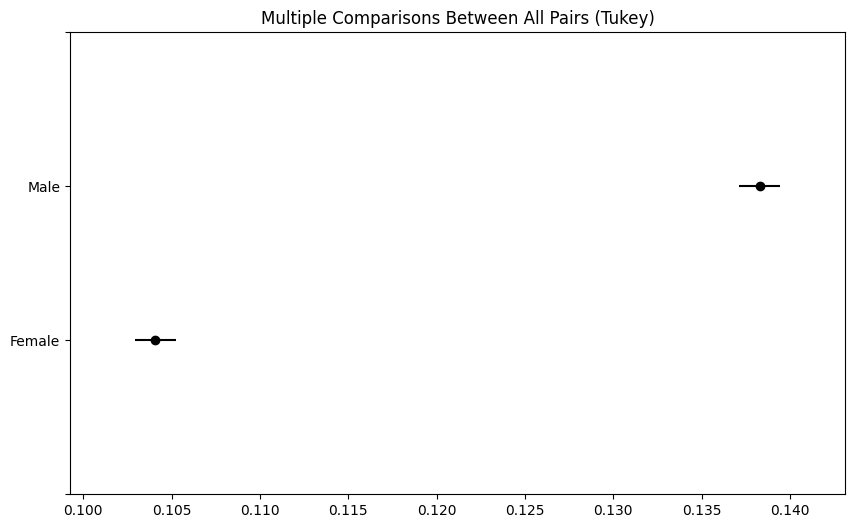

In [443]:
import matplotlib.pyplot as plt

r.plot_simultaneous()
plt.show()

#### 데이터 전처리

In [444]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)

In [445]:
dfX.head(2)

,ID,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,0,Female,23,1,8.0000,0,< 1 Year,Yes,"61,354.0000",152.0000,235
1,1,Male,27,1,28.0000,1,< 1 Year,No,"38,036.0000",152.0000,207


In [446]:
dfX.isna().sum()

ID                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [464]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   ID                    381109 non-null  int64   
 1   Gender                381109 non-null  int8    
 2   Age                   381109 non-null  int64   
 3   Driving_License       381109 non-null  int64   
 4   Region_Code           381109 non-null  float64 
 5   Previously_Insured    381109 non-null  int64   
 6   Vehicle_Age           381109 non-null  category
 7   Vehicle_Damage        381109 non-null  int64   
 8   Annual_Premium        381109 non-null  float64 
 9   Policy_Sales_Channel  381109 non-null  float64 
 10  Vintage               381109 non-null  int64   
dtypes: category(1), float64(3), int64(6), int8(1)
memory usage: 26.9 MB


In [449]:
dfX['Gender'].value_counts()

Gender
Male      206033
Female    175076
Name: count, dtype: int64

In [452]:
dfX['Gender'] = dfX['Gender'].astype('category').cat.codes

In [453]:
dfX['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     200282
< 1 Year     164885
> 2 Years     15942
Name: count, dtype: int64

In [459]:
dfX['Vehicle_Age'] = pd.Categorical(dfX['Vehicle_Age'], categories=['< 1 Year', '1-2 Year', '> 2 Years'], ordered=True)

In [475]:
dfX['Vehicle_Age'] = dfX['Vehicle_Age'].cat.codes

In [461]:
dfX['Vehicle_Damage'].value_counts()

Vehicle_Damage
Yes    192072
No     189037
Name: count, dtype: int64

In [463]:
dfX['Vehicle_Damage'] = dfX['Vehicle_Damage'].replace({'No':0, 'Yes':1})

#### Feature Engineering

In [465]:
dfX.columns

Index(['ID', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [466]:
x_features = ['Gender', 'Age', 'Driving_License', 'Region_Code','Previously_Insured', 'Vehicle_Age', \
              'Vehicle_Damage', 'Annual_Premium','Policy_Sales_Channel', 'Vintage']

In [467]:
Y.columns

Index(['ID', 'Response'], dtype='object')

In [468]:
y_feature = 'Response'

#### 모델링

In [476]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

In [477]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=1234, stratify=YF)

In [496]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=True)

In [498]:
result.sort_values(['Train_Accuracy', 'DIFF', 'Test_Accuracy'], ascending=[False, True, False])

,Train_Accuracy,Test_Accuracy,DIFF,ROC_AUC
DecisionTreeClassifier,0.9999,0.8225,0.1774,0.6020
RandomForestClassifier,0.9999,0.8674,0.1325,0.8340
KNeighborsClassifier,0.8851,0.8592,0.0260,0.5962
XGBClassifier,0.8823,0.8767,0.0056,0.8560
RandomForestClassifier_9,0.8774,0.8774,0.0000,0.8547
LogisticRegression,0.8774,0.8774,0.0000,0.5981
RandomForestClassifier_1,0.8774,0.8774,0.0000,0.8166
RandomForestClassifier_2,0.8774,0.8774,0.0000,0.8291
RandomForestClassifier_3,0.8774,0.8774,0.0000,0.8395
RandomForestClassifier_4,0.8774,0.8774,0.0000,0.8447


In [500]:
model = RandomForestClassifier(random_state=1234).fit(xtrain, ytrain)

In [501]:
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=True))

Train_Accuracy   0.9999
Test_Accuracy    0.8674
ROC_AUC          0.8340
dtype: float64


Y_pred = model.predict(X_submissionF)

In [531]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['Importance'])

,Importance
Gender,0.0138
Age,0.1423
Driving_License,0.0005
Region_Code,0.1130
Previously_Insured,0.0560
Vehicle_Age,0.0223
Vehicle_Damage,0.0693
Annual_Premium,0.2441
Policy_Sales_Channel,0.0676
Vintage,0.2712


In [505]:
submission = pd.DataFrame({'ID': X_submission['ID'], \
                          'Response': Y_pred})
submission.head(2)

,ID,Response
0,17,0
1,19,0


In [506]:
submission.to_csv('./submission.csv', index=False)

#### 실제값과 비교 (Accuracy Score)

In [509]:
Y_actual = Y_submission
Y_actual.head(2)

,ID,Response
0,17,0
1,19,0


In [510]:
Y_prediction = pd.read_csv('./submission.csv')
Y_prediction.head(2)

,ID,Response
0,17,0
1,19,0


In [511]:
accuracy_score(Y_actual['Response'],Y_prediction['Response'])

0.9596179580698486

In [512]:
precision_score(Y_actual['Response'],Y_prediction['Response'])

0.9247716281569048

In [513]:
recall_score(Y_actual['Response'],Y_prediction['Response'])

0.7321846415656244

In [514]:
f1_score(Y_actual['Response'],Y_prediction['Response'])

0.817286002611896

### 비행탑승 경험 만족도 데이터

```{attention}    
데이터 설명 : 비행탑승 경험 만족도 (satisfaction 컬럼 : 'neutral or dissatisfied' or satisfied )   (83123, 24) shape     
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/y_test.csv    
데이터 출처 :https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction?select=train.csv (참고, 데이터 수정)  
```  

```{attention}    
**test 데이터에 대해서 neutral or dissatisfied라고 예측할 확률을 구하고 그 확률 값을 제출하라**
```  

In [127]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
#데이터 로드
X = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/x_train.csv")
Y = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/y_train.csv")
X_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/x_test.csv")
Y_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/airline/y_test.csv")

X.drop(columns='id', inplace=True)
X_submission.drop(columns='id', inplace=True)

display(X.head())
display(Y.head())

,ID,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,Female,Loyal Customer,54,Personal Travel,Eco,1068,3,4,3,1,5,4,4,5,5,3,5,3,5,3,47,22.0000
1,2,Male,Loyal Customer,20,Personal Travel,Eco,1546,4,4,4,4,4,4,4,4,3,3,4,4,4,4,5,2.0000
2,3,Male,Loyal Customer,59,Business travel,Business,2962,0,4,0,4,2,4,5,1,1,1,1,5,1,4,54,46.0000
3,4,Male,Loyal Customer,35,Business travel,Eco Plus,106,5,4,4,4,5,5,5,5,2,1,5,4,4,5,130,121.0000
4,5,Female,Loyal Customer,9,Business travel,Business,2917,3,3,3,3,4,4,4,4,4,4,5,4,3,4,0,0.0000


,ID,satisfaction
0,0,neutral or dissatisfied
1,2,neutral or dissatisfied
2,3,satisfied
3,4,satisfied
4,5,satisfied


#### EDA

In [128]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83123 entries, 0 to 83122
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 83123 non-null  int64  
 1   Gender                             83123 non-null  object 
 2   Customer Type                      83123 non-null  object 
 3   Age                                83123 non-null  int64  
 4   Type of Travel                     83123 non-null  object 
 5   Class                              83123 non-null  object 
 6   Flight Distance                    83123 non-null  int64  
 7   Inflight wifi service              83123 non-null  int64  
 8   Departure/Arrival time convenient  83123 non-null  int64  
 9   Ease of Online booking             83123 non-null  int64  
 10  Gate location                      83123 non-null  int64  
 11  Food and drink                     83123 non-null  int

In [129]:
X_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20781 entries, 0 to 20780
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 20781 non-null  int64  
 1   Gender                             20781 non-null  object 
 2   Customer Type                      20781 non-null  object 
 3   Age                                20781 non-null  int64  
 4   Type of Travel                     20781 non-null  object 
 5   Class                              20781 non-null  object 
 6   Flight Distance                    20781 non-null  int64  
 7   Inflight wifi service              20781 non-null  int64  
 8   Departure/Arrival time convenient  20781 non-null  int64  
 9   Ease of Online booking             20781 non-null  int64  
 10  Gate location                      20781 non-null  int64  
 11  Food and drink                     20781 non-null  int

In [130]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83123 entries, 0 to 83122
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            83123 non-null  int64 
 1   satisfaction  83123 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [131]:
Y['satisfaction'].value_counts()

satisfaction
neutral or dissatisfied    47103
satisfied                  36020
Name: count, dtype: int64

In [132]:
features = X.select_dtypes(include='object').columns
features

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object')

In [133]:
for feature in features:
    print(f'{feature}')
    print(X[feature].value_counts())
    print("-" * 30)

Gender
Gender
Female    42284
Male      40839
Name: count, dtype: int64
------------------------------
Customer Type
Customer Type
Loyal Customer       67951
disloyal Customer    15172
Name: count, dtype: int64
------------------------------
Type of Travel
Type of Travel
Business travel    57370
Personal Travel    25753
Name: count, dtype: int64
------------------------------
Class
Class
Business    39791
Eco         37349
Eco Plus     5983
Name: count, dtype: int64
------------------------------


In [134]:
dfXY = pd.merge(X, Y, on='ID')
dfXY.head(2)

,ID,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,Female,Loyal Customer,54,Personal Travel,Eco,1068,3,4,3,1,5,4,4,5,5,3,5,3,5,3,47,22.0000,neutral or dissatisfied
1,2,Male,Loyal Customer,20,Personal Travel,Eco,1546,4,4,4,4,4,4,4,4,3,3,4,4,4,4,5,2.0000,neutral or dissatisfied


In [135]:
print([x.shape for x in [X, Y, dfXY]])

[(83123, 23), (83123, 2), (83123, 24)]


In [136]:
dfXY['satisfaction'] = LabelEncoder().fit_transform(dfXY['satisfaction'])

In [137]:
dfXY.corr(numeric_only=True)['satisfaction'].sort_values(ascending=False)

satisfaction                         1.0000
Online boarding                      0.5041
Inflight entertainment               0.3998
Seat comfort                         0.3530
On-board service                     0.3233
Leg room service                     0.3127
Cleanliness                          0.3061
Flight Distance                      0.3004
Inflight wifi service                0.2812
Baggage handling                     0.2467
Inflight service                     0.2449
Checkin service                      0.2350
Food and drink                       0.2107
Ease of Online booking               0.1694
Age                                  0.1390
ID                                   0.0054
Gate location                       -0.0020
Departure Delay in Minutes          -0.0531
Departure/Arrival time convenient   -0.0535
Arrival Delay in Minutes            -0.0600
Name: satisfaction, dtype: float64

In [138]:
for feature in features:
    print(f'{feature}')
    print(dfXY.groupby('satisfaction')[feature].value_counts(normalize=True))
    print("-" * 30)

Gender
satisfaction  Gender
0             Female   0.5129
              Male     0.4871
1             Female   0.5032
              Male     0.4968
Name: proportion, dtype: float64
------------------------------
Customer Type
satisfaction  Customer Type    
0             Loyal Customer      0.7533
              disloyal Customer   0.2467
1             Loyal Customer      0.9014
              disloyal Customer   0.0986
Name: proportion, dtype: float64
------------------------------
Type of Travel
satisfaction  Type of Travel 
0             Business travel   0.5088
              Personal Travel   0.4912
1             Business travel   0.9274
              Personal Travel   0.0726
Name: proportion, dtype: float64
------------------------------
Class
satisfaction  Class   
0             Eco        0.6461
              Business   0.2583
              Eco Plus   0.0956
1             Business   0.7669
              Eco        0.1920
              Eco Plus   0.0411
Name: proportion, dtype: flo

#### 데이터전처리

In [139]:
X.isna().sum()

ID                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             256
dtype: int64

In [140]:
X['Arrival Delay in Minutes'].mean()

15.132477343212617

In [141]:
X_submission.isna().sum()

ID                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             72
dtype: int64

In [142]:
X_submission['Arrival Delay in Minutes'].mean()

14.99449514703752

In [143]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)

In [165]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ID                                 103904 non-null  int64  
 1   Gender                             103904 non-null  int8   
 2   Customer Type                      103904 non-null  int32  
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  int32  
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [164]:
dfX.isna().sum()

ID                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Business                             0
Eco                                  0
Eco Plus                             0
dtype: int64

In [146]:
for feature in features:
    print(dfX.groupby(feature)['Arrival Delay in Minutes'].mean())
    print('-' * 30)

Gender
Female   15.0614
Male     15.1499
Name: Arrival Delay in Minutes, dtype: float64
------------------------------
Customer Type
Loyal Customer      15.0020
disloyal Customer   15.5653
Name: Arrival Delay in Minutes, dtype: float64
------------------------------
Type of Travel
Business travel   15.3216
Personal Travel   14.6217
Name: Arrival Delay in Minutes, dtype: float64
------------------------------
Class
Business   14.5041
Eco        15.5750
Eco Plus   16.1626
Name: Arrival Delay in Minutes, dtype: float64
------------------------------


In [147]:
dfX.loc[dfX['Class'] == 'Business', 'Arrival Delay in Minutes'].mean()

14.50408455533816

In [148]:
dfX.loc[dfX['Class'] == 'Business', 'Arrival Delay in Minutes'] = \
dfX.loc[dfX['Class'] == 'Business', 'Arrival Delay in Minutes'].fillna( \
  dfX.loc[dfX['Class'] == 'Business', 'Arrival Delay in Minutes'].mean())

In [149]:
dfX.loc[dfX['Class'] == 'Eco', 'Arrival Delay in Minutes'] = \
dfX.loc[dfX['Class'] == 'Eco', 'Arrival Delay in Minutes'].fillna( \
  dfX.loc[dfX['Class'] == 'Eco', 'Arrival Delay in Minutes'].mean())

In [150]:
dfX.loc[dfX['Class'] == 'Eco Plus', 'Arrival Delay in Minutes'] = \
dfX.loc[dfX['Class'] == 'Eco Plus', 'Arrival Delay in Minutes'].fillna( \
  dfX.loc[dfX['Class'] == 'Eco Plus', 'Arrival Delay in Minutes'].mean())

In [151]:
for feature in features:
    print(f'{feature:20s} - {dfX[feature].unique()}')

Gender               - ['Female' 'Male']
Customer Type        - ['Loyal Customer' 'disloyal Customer']
Type of Travel       - ['Personal Travel' 'Business travel']
Class                - ['Eco' 'Business' 'Eco Plus']


In [152]:
dfX['Gender'] = dfX['Gender'].astype('category').cat.codes

In [153]:
dfX['Customer Type'] = LabelEncoder().fit_transform(dfX['Customer Type'])

In [154]:
dfX['Type of Travel'] = LabelEncoder().fit_transform(dfX['Type of Travel'])

In [155]:
temp = pd.get_dummies(dfX['Class'])
dfX.drop(columns=['Class'], inplace=True)
dfX = pd.concat([dfX, temp], axis=1)

In [158]:
Y['satisfaction'] = Y['satisfaction'].replace({'neutral or dissatisfied': 1, 'satisfied':0})

In [159]:
dfXY = pd.merge(dfX, Y, on='ID')

In [160]:
dfXY.corr(numeric_only=True)['satisfaction'].sort_values(ascending=False)

satisfaction                         1.0000
Eco                                  0.4524
Type of Travel                       0.4486
Customer Type                        0.1900
Eco Plus                             0.1043
Arrival Delay in Minutes             0.0600
Departure/Arrival time convenient    0.0535
Departure Delay in Minutes           0.0531
Gate location                        0.0020
ID                                  -0.0054
Gender                              -0.0097
Age                                 -0.1390
Ease of Online booking              -0.1694
Food and drink                      -0.2107
Checkin service                     -0.2350
Inflight service                    -0.2449
Baggage handling                    -0.2467
Inflight wifi service               -0.2812
Flight Distance                     -0.3004
Cleanliness                         -0.3061
Leg room service                    -0.3127
On-board service                    -0.3233
Seat comfort                    

#### Feature Engineering

In [166]:
x_features = ['Gender', 'Customer Type', 'Age', 'Type of Travel','Flight Distance', 'Inflight wifi service', \
              'Departure/Arrival time convenient', 'Ease of Online booking','Gate location', 'Food and drink', \
              'Online boarding', 'Seat comfort','Inflight entertainment', 'On-board service', 'Leg room service', \
              'Baggage handling', 'Checkin service', 'Inflight service','Cleanliness', 'Departure Delay in Minutes', \
              'Arrival Delay in Minutes', 'Business', 'Eco', 'Eco Plus']
y_feature = 'satisfaction'

#### 모델링

In [167]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

print([x.shape for x in [X, Y, X_submission]])
print([x.shape for x in [XF, YF, X_submissionF]])

[(83123, 23), (83123, 2), (20781, 23)]
[(83123, 24), (83123,), (20781, 24)]


In [168]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=1234, stratify=YF)

print([x.shape for x in [xtrain, ytrain, xtest, ytest]])

[(58186, 24), (58186,), (24937, 24), (24937,)]


In [176]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=True)

In [178]:
result.sort_values(['Test_Accuracy', 'ROC_AUC'], ascending=[False, False])

,Train_Accuracy,Test_Accuracy,DIFF,ROC_AUC
RandomForestClassifier,1.0000,0.9623,0.0377,0.9935
XGBClassifier,0.9802,0.9609,0.0192,0.9945
DecisionTreeClassifier,1.0000,0.9425,0.0575,0.9423
LogisticRegression,0.8763,0.8734,0.0030,0.9266
KNeighborsClassifier,0.8231,0.7354,0.0878,0.7872


In [180]:
model = RandomForestClassifier(random_state=1234).fit(xtrain, ytrain)
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=True))

Train_Accuracy   1.0000
Test_Accuracy    0.9623
ROC_AUC          0.9935
dtype: float64


In [194]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['Importance']) \
   .sort_values('Importance', ascending=False)

,Importance
Online boarding,0.1519
Inflight wifi service,0.1368
Type of Travel,0.0858
Business,0.0828
Inflight entertainment,0.0524
Eco,0.0502
Seat comfort,0.0498
Ease of Online booking,0.0395
Flight Distance,0.0377
Leg room service,0.0351


In [182]:
Y_pred = model.predict_proba(X_submissionF)[:,1]

submission = pd.DataFrame({'ID': X_submission['ID'], \
                           'satisfaction': Y_pred})

submission.to_csv('./submission.csv', index=False)

#### 실제값과 비교 (ROC AUC Score)

In [183]:
Y_actual = Y_submission
Y_predict = pd.read_csv('./submission.csv')

In [187]:
Y_actual['satisfaction'] = Y_actual['satisfaction'].replace({'neutral or dissatisfied': 1, 'satisfied':0})

In [188]:
Y_actual.head(2)

,ID,satisfaction
0,1,1
1,16,1


In [189]:
Y_predict.head(2)

,ID,satisfaction
0,1,0.8200
1,16,0.9700


In [190]:
roc_auc_score(Y_actual[y_feature], Y_predict[y_feature])

0.9991164455174786

### 수질 음용성 여부 데이터

```{attention} 
데이터 설명 : 수질 음용성 여부 (Potablillity 컬럼 : 0 ,1 )     
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/y_test.csv    
데이터 출처 :https://www.kaggle.com/adityakadiwal/water-potability    
```  

In [197]:
import pandas as pd
#데이터 로드
X = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/x_train.csv")
Y = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/y_train.csv")
X_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/x_test.csv")
Y_actual = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/waters/y_test.csv")

display(X.head())
display(Y.head())

,ID,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0,8.6627,173.5319,"20,333.0795",5.6364,439.7879,459.6331,16.2833,89.9243,5.1201
1,1,NaN,226.2708,"15,380.1241",6.6615,NaN,392.5582,14.0831,50.2864,4.5169
2,2,7.5838,217.2833,"36,343.4071",8.5327,375.9644,393.8777,17.4423,77.7223,3.6423
3,3,6.5848,182.3755,"24,723.1063",6.2389,NaN,414.3508,17.5826,78.2137,4.4041
4,4,7.1799,180.8542,"10,859.5538",8.2635,341.3025,358.0563,12.0653,83.3299,3.8784


,ID,Potability
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0


#### EDA

In [198]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2620 non-null   int64  
 1   ph               2225 non-null   float64
 2   Hardness         2620 non-null   float64
 3   Solids           2620 non-null   float64
 4   Chloramines      2620 non-null   float64
 5   Sulfate          2003 non-null   float64
 6   Conductivity     2620 non-null   float64
 7   Organic_carbon   2620 non-null   float64
 8   Trihalomethanes  2488 non-null   float64
 9   Turbidity        2620 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 204.8 KB


In [199]:
X_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               656 non-null    int64  
 1   ph               549 non-null    float64
 2   Hardness         656 non-null    float64
 3   Solids           656 non-null    float64
 4   Chloramines      656 non-null    float64
 5   Sulfate          504 non-null    float64
 6   Conductivity     656 non-null    float64
 7   Organic_carbon   656 non-null    float64
 8   Trihalomethanes  618 non-null    float64
 9   Turbidity        656 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 51.4 KB


In [200]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          2620 non-null   int64
 1   Potability  2620 non-null   int64
dtypes: int64(2)
memory usage: 41.1 KB


In [201]:
X.select_dtypes(include='object').columns

Index([], dtype='object')

In [204]:
dfXY = pd.merge(X, Y, on='ID')

In [209]:
dfXY.corr()['Potability'].sort_values(ascending=False)

Potability         1.0000
Solids             0.0190
ph                 0.0178
Conductivity       0.0141
ID                 0.0100
Chloramines        0.0055
Trihalomethanes    0.0012
Turbidity         -0.0043
Hardness          -0.0106
Organic_carbon    -0.0285
Sulfate           -0.0437
Name: Potability, dtype: float64

#### 데이터전처리

In [210]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=False)

In [230]:
dfX.isna().sum()

ID                 0
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

In [212]:
dfX['ph'].value_counts()

ph
6.9870    2
6.9534    2
7.5357    2
4.3283    2
8.4379    2
         ..
7.7540    1
8.0821    1
7.0318    1
7.1190    1
7.9331    1
Name: count, Length: 2225, dtype: int64

In [215]:
X['ph'].mean(), X_submission['ph'].mean(), X['ph'].median(), X_submission['ph'].median()

(7.059706555058334, 7.109372787913072, 7.025504334993, 7.061845519716819)

In [217]:
dfX['ph'] = dfX['ph'].fillna(dfX['ph'].mean())

In [219]:
dfX['Sulfate'].value_counts()

Sulfate
380.0782    2
371.2838    2
311.7949    2
316.8202    2
327.6975    2
           ..
336.4660    1
395.4960    1
351.5733    1
418.2472    1
331.0872    1
Name: count, Length: 2003, dtype: int64

In [224]:
X['Sulfate'].mean(), X_submission['Sulfate'].mean(), dfX['Sulfate'].mean(), \
X['Sulfate'].median(), X_submission['Sulfate'].median(), dfX['Sulfate'].median()

(333.1284518718297,
 335.1351121171081,
 333.5318650204617,
 332.2393594928603,
 333.3154288686785,
 332.7445191883906)

In [225]:
dfX['Sulfate'] = dfX['Sulfate'].fillna(dfX['Sulfate'].mean())

In [227]:
dfX['Trihalomethanes'].value_counts()

Trihalomethanes
54.0609    2
44.7890    2
35.2212    2
62.2977    2
46.5046    2
          ..
88.0490    1
45.7213    1
70.3684    1
86.9797    1
55.4041    1
Name: count, Length: 2488, dtype: int64

In [228]:
X['Trihalomethanes'].mean(), X_submission['Trihalomethanes'].mean(), dfX['Trihalomethanes'].mean(), \
X['Trihalomethanes'].median(), X_submission['Trihalomethanes'].median(), dfX['Trihalomethanes'].median()

(66.36231333912505,
 66.34604182323474,
 66.35907579990412,
 66.36358047027184,
 65.81625396036834,
 66.23041500603713)

In [229]:
dfX['Trihalomethanes'] = dfX['Trihalomethanes'].fillna(dfX['Trihalomethanes'].mean())

In [231]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3276 entries, 0 to 655
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               3276 non-null   int64  
 1   ph               3276 non-null   float64
 2   Hardness         3276 non-null   float64
 3   Solids           3276 non-null   float64
 4   Chloramines      3276 non-null   float64
 5   Sulfate          3276 non-null   float64
 6   Conductivity     3276 non-null   float64
 7   Organic_carbon   3276 non-null   float64
 8   Trihalomethanes  3276 non-null   float64
 9   Turbidity        3276 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 281.5 KB


In [234]:
dfXY = pd.merge(dfX, Y, on='ID')

In [236]:
dfXY.corr()['Potability']

ID                 0.0100
ph                 0.0164
Hardness          -0.0106
Solids             0.0190
Chloramines        0.0055
Sulfate           -0.0384
Conductivity       0.0141
Organic_carbon    -0.0285
Trihalomethanes    0.0012
Turbidity         -0.0043
Potability         1.0000
Name: Potability, dtype: float64

#### Feature Engineering

In [238]:
x_features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate','Conductivity', \
              'Organic_carbon', 'Trihalomethanes', 'Turbidity']
y_feature = 'Potability'

#### 모델링

In [239]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

print([x.shape for x in [X, Y, X_submission]])
print([x.shape for x in [XF, YF, X_submissionF]])

[(2620, 10), (2620, 2), (656, 10)]
[(2620, 9), (2620,), (656, 9)]


In [240]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=0, stratify=YF)

print([x.shape for x in [xtrain, xtest, ytrain, ytest]])

[(1834, 9), (786, 9), (1834,), (786,)]


In [246]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=False)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}


In [247]:
result.sort_values(['Accuracy'], ascending=[False])

,Train_Accuracy,Test_Accuracy,DIFF,Accuracy,Precision,Recall,F1
XGBClassifier,1.0000,0.6183,0.3817,0.6183,0.5148,0.3974,0.4485
RandomForestClassifier,0.7137,0.6145,0.0992,0.6145,0.5345,0.1010,0.1699
DecisionTreeClassifier,1.0000,0.5700,0.4300,0.5700,0.4543,0.5016,0.4768
KNeighborsClassifier,0.7050,0.5611,0.1439,0.5611,0.4159,0.3062,0.3527


In [249]:
model = RandomForestClassifier(random_state=1234, criterion='gini', max_depth=7, n_estimators=300).fit(xtrain, ytrain)
get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=False)

Train_Accuracy   0.7137
Test_Accuracy    0.6145
Accuracy         0.6145
Precision        0.5345
Recall           0.1010
F1               0.1699
dtype: float64

In [251]:
model = XGBClassifier().fit(xtrain, ytrain)
get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=False)

Train_Accuracy   1.0000
Test_Accuracy    0.6183
Accuracy         0.6183
Precision        0.5148
Recall           0.3974
F1               0.4485
dtype: float64

In [265]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['Importance'])

,Importance
ph,0.1202
Hardness,0.1086
Solids,0.1120
Chloramines,0.1187
Sulfate,0.1607
Conductivity,0.0939
Organic_carbon,0.1006
Trihalomethanes,0.0938
Turbidity,0.0915


In [254]:
Y_pred = model.predict(X_submissionF)

submission = pd.DataFrame({'ID': X_submission['ID'], 'Potability': Y_pred})
submission.to_csv('./submission.csv', index=False)

#### 실제값과 비교 (Accuracy Score)

In [255]:
Y_predict = pd.read_csv('./submission.csv')

display(Y_actual.head(2))
display(Y_predict.head(2))

,ID,Potability
0,16,0
1,20,1


,ID,Potability
0,16,1
1,20,1


In [256]:
accuracy_score(Y_actual[y_feature], Y_predict[y_feature])

0.8765243902439024

In [257]:
precision_score(Y_actual[y_feature], Y_predict[y_feature])

0.8594377510040161

In [259]:
recall_score(Y_actual[y_feature], Y_predict[y_feature])

0.823076923076923

In [260]:
f1_score(Y_actual[y_feature], Y_predict[y_feature])

0.8408644400785854

In [262]:
pd.DataFrame(confusion_matrix(Y_actual[y_feature], Y_predict[y_feature]), \
             index=[0, 1], columns=[0, 1])

,0,1
0,361,35
1,46,214


### 약물 분류 데이터

```{attention}  
데이터 설명 : 투약하는 약을 분류  (종속변수 :Drug)   
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/y_test.csv    
데이터 출처 :https://www.kaggle.com/prathamtripathi/drug-classification(참고, 데이터 수정)   
```  

In [3]:
import pandas as pd

X = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/x_train.csv")
Y = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/y_train.csv")
X_submission = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/x_test.csv")
Y_actual = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/drug/y_test.csv")

display(X.head())
display(Y.head())

,ID,Age,Sex,BP,Cholesterol,Na_to_K
0,0,36,F,NORMAL,HIGH,16.753
1,1,47,F,LOW,HIGH,11.767
2,2,69,F,NORMAL,HIGH,10.065
3,3,35,M,LOW,NORMAL,9.170
4,4,49,M,LOW,NORMAL,11.014


,ID,Drug
0,0,0
1,1,3
2,2,4
3,3,4
4,4,4


#### EDA

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           157 non-null    int64  
 1   Age          157 non-null    int64  
 2   Sex          157 non-null    object 
 3   BP           157 non-null    object 
 4   Cholesterol  157 non-null    object 
 5   Na_to_K      157 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 7.5+ KB


In [6]:
X_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           43 non-null     int64  
 1   Age          43 non-null     int64  
 2   Sex          43 non-null     object 
 3   BP           43 non-null     object 
 4   Cholesterol  43 non-null     object 
 5   Na_to_K      43 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.1+ KB


In [7]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      157 non-null    int64
 1   Drug    157 non-null    int64
dtypes: int64(2)
memory usage: 2.6 KB


In [47]:
dfXY = pd.merge(X, Y, on='ID')

In [48]:
dfXY.head(2)

,ID,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,0,36,F,NORMAL,HIGH,16.7530,0
1,1,47,F,LOW,HIGH,11.7670,3


In [49]:
dfXY.corr(numeric_only=True)['Drug']

ID        -0.0721
Age        0.0574
Na_to_K   -0.7041
Drug       1.0000
Name: Drug, dtype: float64

In [50]:
features = X.select_dtypes(include='object').columns
features

Index(['Sex', 'BP', 'Cholesterol'], dtype='object')

In [52]:
dfXY['Drug'].value_counts(normalize=True)

0   0.4586
4   0.2739
1   0.1146
3   0.0764
2   0.0764
Name: Drug, dtype: float64

In [16]:
for feature in features:
    print(f'{feature}')
    print(dfXY.groupby('Drug')[feature].value_counts(normalize=True))
    print('-' * 30)

Sex
Drug  Sex
0     F      0.513889
      M      0.486111
1     M      0.611111
      F      0.388889
2     M      0.583333
      F      0.416667
3     M      0.750000
      F      0.250000
4     M      0.534884
      F      0.465116
Name: Sex, dtype: float64
------------------------------
BP
Drug  BP    
0     HIGH      0.472222
      LOW       0.277778
      NORMAL    0.250000
1     HIGH      1.000000
2     HIGH      1.000000
3     LOW       1.000000
4     NORMAL    0.651163
      LOW       0.348837
Name: BP, dtype: float64
------------------------------
Cholesterol
Drug  Cholesterol
0     NORMAL         0.513889
      HIGH           0.486111
1     HIGH           0.500000
      NORMAL         0.500000
2     HIGH           0.500000
      NORMAL         0.500000
3     HIGH           1.000000
4     NORMAL         0.651163
      HIGH           0.348837
Name: Cholesterol, dtype: float64
------------------------------


#### 데이터전처리

In [17]:
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           200 non-null    int64  
 1   Age          200 non-null    int64  
 2   Sex          200 non-null    object 
 3   BP           200 non-null    object 
 4   Cholesterol  200 non-null    object 
 5   Na_to_K      200 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [18]:
dfX.isna().sum()

ID             0
Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
dtype: int64

In [19]:
for feature in dfX.select_dtypes(include='object').columns:
    print(f'{feature} = {dfX[feature].unique()}')

Sex = ['F' 'M']
BP = ['NORMAL' 'LOW' 'HIGH']
Cholesterol = ['HIGH' 'NORMAL']


In [21]:
dfX['Sex'] = dfX['Sex'].replace({'F': 0, 'M': 1})

In [24]:
temp = dfX.drop(columns='BP')
dfX = pd.concat([temp, pd.get_dummies(dfX['BP'], prefix='BP')], axis=1)
dfX.head(2)

,ID,Age,Sex,Cholesterol,Na_to_K,BP_HIGH,BP_LOW,BP_NORMAL
0,0,36,0,HIGH,16.753,0,0,1
1,1,47,0,HIGH,11.767,0,1,0


In [25]:
temp = dfX.drop(columns='Cholesterol')
dfX = pd.concat([temp, pd.get_dummies(dfX['Cholesterol'], prefix='Cholesterol')], axis=1)
dfX.head(2)

,ID,Age,Sex,Na_to_K,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,0,36,0,16.753,0,0,1,1,0
1,1,47,0,11.767,0,1,0,1,0


In [26]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  200 non-null    int64  
 1   Age                 200 non-null    int64  
 2   Sex                 200 non-null    int64  
 3   Na_to_K             200 non-null    float64
 4   BP_HIGH             200 non-null    uint8  
 5   BP_LOW              200 non-null    uint8  
 6   BP_NORMAL           200 non-null    uint8  
 7   Cholesterol_HIGH    200 non-null    uint8  
 8   Cholesterol_NORMAL  200 non-null    uint8  
dtypes: float64(1), int64(3), uint8(5)
memory usage: 7.4 KB


In [33]:
dfXY = pd.merge(dfX, Y, on='ID')

In [34]:
dfXY.corr()['Drug']

ID                   -0.0721
Age                   0.0574
Sex                   0.0643
Na_to_K              -0.7041
BP_HIGH              -0.4518
BP_LOW                0.1712
BP_NORMAL             0.3155
Cholesterol_HIGH     -0.0416
Cholesterol_NORMAL    0.0416
Drug                  1.0000
Name: Drug, dtype: float64

#### Feature Engineering

In [32]:
dfX.columns

Index(['ID', 'Age', 'Sex', 'Na_to_K', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_HIGH', 'Cholesterol_NORMAL'],
      dtype='object')

In [35]:
Y.columns

Index(['ID', 'Drug'], dtype='object')

In [37]:
x_features = ['Age', 'Sex', 'Na_to_K', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL','Cholesterol_HIGH', 'Cholesterol_NORMAL']
y_feature = 'Drug'

#### 모델링

In [39]:
XF, X_submissionF, YF = get_classification_model_data(dfX, Y, len(X), x_features, y_feature, is_normalized=False)

print([x.shape for x in [X, Y, X_submission]])
print([x.shape for x in [XF, YF, X_submissionF]])

[(157, 6), (157, 2), (43, 6)]
[(157, 8), (157,), (43, 8)]


In [40]:
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=1234, stratify=YF)

print([x.shape for x in [xtrain, xtest, ytrain, ytest]])

[(109, 8), (48, 8), (109,), (48,)]


In [54]:
result = compare_classification_model(xtrain, xtest, ytrain, ytest, is_binary_model=False)

In [56]:
result.sort_values(['Accuracy', 'Precision', 'Recall', 'F1'], ascending=False)

,Train_Accuracy,Test_Accuracy,DIFF,Accuracy,Precision,Recall,F1
DecisionTreeClassifier,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000
RandomForestClassifier,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000
XGBClassifier,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000
KNeighborsClassifier,0.7890,0.6250,0.1640,0.6250,0.6118,0.6250,0.6100


In [57]:
model = DecisionTreeClassifier(random_state=1234).fit(xtrain, ytrain)
print(get_classification_model_score(model, xtrain, xtest, ytrain, ytest, is_binary_model=False))

Train_Accuracy   1.0000
Test_Accuracy    1.0000
Accuracy         1.0000
Precision        1.0000
Recall           1.0000
F1               1.0000
dtype: float64


In [59]:
Y_pred = model.predict(X_submissionF)

submission = pd.DataFrame({'ID': X_submission['ID'], 
                           'Drug': Y_pred})
submission.to_csv('./submission.csv', index=False)
submission.head(2)

,ID,Drug
0,8,0
1,9,4


In [61]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['Importance']).sort_values('Importance', ascending=False)

,Importance
Na_to_K,0.4844
BP_HIGH,0.2154
Age,0.1319
Cholesterol_NORMAL,0.1128
BP_LOW,0.0554
Sex,0.0000
BP_NORMAL,0.0000
Cholesterol_HIGH,0.0000


#### 실제값과 비교 (Accuracy, Precision, Recall, F1 Score)

In [62]:
Y_predict = pd.read_csv('./submission.csv')
display(Y_actual.head())
display(Y_predict.head())

,ID,Drug
0,8,0
1,9,4
2,14,1
3,25,4
4,26,0


,ID,Drug
0,8,0
1,9,4
2,14,1
3,25,4
4,26,0


In [65]:
pd.DataFrame(confusion_matrix(Y_actual['Drug'], Y_predict['Drug']), index=range(0,5), columns=range(0,5))

,0,1,2,3,4
0,15,0,0,0,0
1,0,7,0,0,0
2,0,0,5,0,0
3,0,0,0,3,0
4,0,0,0,0,13


In [81]:
print(f'Accuracy  Score: {accuracy_score(Y_actual.Drug, Y_predict.Drug):.4f}')
print(f'Precision Score: {precision_score(Y_actual.Drug, Y_predict.Drug, average="macro"):.4f}')
print(f'Recall    Score: {recall_score(Y_actual.Drug, Y_predict.Drug, average="macro"):.4f}')
print(f'F1        Score: {f1_score(Y_actual.Drug, Y_predict.Drug, average="macro"):.4f}')

Accuracy  Score: 1.0000
Precision Score: 1.0000
Recall    Score: 1.0000
F1        Score: 1.0000


### 사기회사 분류 데이터

```{attention} 
데이터 설명 : 사기회사 분류  (종속변수 : Risk 1: 사기 , 0 : 정상)     
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/y_test.csv    
데이터 출처 :https://www.kaggle.com/sid321axn/audit-data(참고, 데이터 수정)    
```  

In [59]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/audit/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,...,PROB,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk
0,0,2.37,16,0.01,0.2,0.002,0.007,0.2,0.0014,0.017,...,0.2,0.4,0,0.2,0.0,2.0,1.4034,0.4,0.5,0.28068
1,2,55.57,9,1.06,0.4,0.424,0.000,0.2,0.0000,1.060,...,0.2,0.4,0,0.2,0.0,2.2,1.8240,0.4,0.5,0.36480
2,3,55.57,16,2.42,0.6,1.452,3.530,0.6,2.1180,5.950,...,0.2,0.4,0,0.2,0.0,3.8,7.4940,0.4,0.5,1.49880
3,4,2.37,9,0.31,0.2,0.062,0.690,0.2,0.1380,1.000,...,0.2,0.4,0,0.2,0.0,2.0,1.6000,0.4,0.5,0.32000
4,5,55.57,6,0.62,0.2,0.124,0.420,0.2,0.0840,1.040,...,0.2,0.4,0,0.2,0.0,2.0,1.6080,0.4,0.5,0.32160


,ID,Risk
0,0,0
1,2,0
2,3,1
3,4,0
4,5,0


### 센서데이터 동작유형 분류 데이터

```{attention} 
데이터 설명 : 센서데이터로 동작 유형 분류  (종속변수 pose : 0 ,1 구분)   
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/y_test.csv    
데이터 출처 :https://www.kaggle.com/kyr7plus/emg-4(참고, 데이터 수정)    
```  

In [61]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/muscle/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,motion_0,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,motion_7,motion_8,...,motion_54,motion_55,motion_56,motion_57,motion_58,motion_59,motion_60,motion_61,motion_62,motion_63
0,0,1.0,-2.0,-1.0,4.0,-5.0,-4.0,1.0,0.0,-15.0,...,0.0,-1.0,-13.0,-3.0,1.0,-1.0,-32.0,-22.0,-2.0,-3.0
1,2,20.0,0.0,0.0,1.0,5.0,6.0,-52.0,18.0,15.0,...,-70.0,-55.0,-38.0,-14.0,-12.0,-8.0,-34.0,-63.0,-87.0,-77.0
2,4,1.0,-1.0,1.0,4.0,-5.0,-8.0,1.0,-3.0,-14.0,...,1.0,12.0,-25.0,0.0,0.0,3.0,2.0,-27.0,1.0,0.0
3,5,13.0,2.0,1.0,-3.0,1.0,3.0,28.0,3.0,12.0,...,0.0,-21.0,-17.0,-2.0,0.0,-4.0,-17.0,-21.0,-21.0,25.0
4,6,-2.0,-7.0,-4.0,-8.0,16.0,44.0,1.0,3.0,-16.0,...,-1.0,2.0,-1.0,1.0,4.0,4.0,-17.0,-38.0,-3.0,3.0


,ID,pose
0,0,1
1,2,0
2,4,1
3,5,0
4,6,1


### 당뇨여부판단 데이터

```{attention}  
데이터 설명 :  당뇨여부 판단하기 (종속변수 Outcome : 1 당뇨 , 0 :정상)         
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/y_test.csv    
데이터 출처 :https://www.kaggle.com/pritsheta/diabetes-dataset(참고, 데이터 수정)    
```  

In [62]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/diabetes/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,8,126,88,36,108,38.5,0.349,49
1,1,0,74,52,10,36,27.8,0.269,22
2,2,1,140,74,26,180,24.1,0.828,23
3,3,6,162,62,0,0,24.3,0.178,50
4,4,2,94,68,18,76,26.0,0.561,21


,ID,Outcome
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


## 회귀

### 학생성적 예측 데이터

```{attention} 
데이터 설명 : 학생성적 예측 (종속변수 :G3)        
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/y_test.csv    
데이터 출처 :https://www.kaggle.com/datasets/ishandutta/student-performance-data-set (참고, 데이터 수정)    
```  

```{admonition} 캐글 공유 코드 저장소 
**본인만의 코드를 작성하고 upvote를 받아 broze medal을 획득 해보세요**
[캐글 노트북 링크](https://www.kaggle.com/datasets/kukuroo3/student-performance-data-set-competition-form/code?select=y_train.csv)
```

In [12]:
!wget https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_train.csv
!wget https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_test.csv
!wget https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/y_train.csv

--2023-06-18 22:18:08--  https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_train.csv
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 73333 (72K) [text/plain]
저장 위치: `X_train.csv'

X_train.csv         100%[===================>]  71.61K  --.-KB/s    /  0.02s   

2023-06-18 22:18:08 (4.14 MB/s) - `X_train.csv' 저장함 [73333/73333]

--2023-06-18 22:18:09--  https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_test.csv
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 39540 (39K) [text/plain]
저장 위치: `X_test.csv'

X_test.csv          100%[===========

In [69]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/studentscore/X_test.csv")


display(x_train.head())
display(y_train.head())

,StudentID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,1714,GP,F,18,U,GT3,T,4,3,other,...,no,4,3,3,1,1,3,0,14,13
1,1254,GP,F,17,U,GT3,T,4,3,health,...,yes,4,4,3,1,3,4,0,13,15
2,1639,GP,F,16,R,GT3,T,4,4,health,...,no,2,4,4,2,3,4,6,10,11
3,1118,GP,M,16,U,GT3,T,4,4,services,...,no,5,3,3,1,3,5,0,15,13
4,1499,GP,M,19,U,GT3,T,3,2,services,...,yes,4,5,4,1,1,4,0,5,0


,StudentID,G3
0,1714,14
1,1254,15
2,1639,11
3,1118,13
4,1499,0


### 중고차 가격 예측 데이터

```{attention} 
데이터 설명 : 중고차 가격 예측 데이터 (종속변수 :G3)        
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_test.csv    
데이터 출처 :https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=vw.csv (참고, 데이터 수정)    
```  

```{admonition} 캐글 공유 코드 저장소 
**본인만의 코드를 작성하고 upvote를 받아 broze medal을 획득 해보세요**
[캐글 노트북 링크](https://www.kaggle.com/datasets/kukuroo3/used-car-price-dataset-competition-format/code?select=y_train.csv)
```

In [71]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/carsprice/X_test.csv")


display(x_train.head())
display(y_train.head())

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0


,carID,price
0,13207,31995
1,17314,7700
2,12342,58990
3,13426,12999
4,16004,16990


### 의료 비용 예측 데이터

```{attention} 
데이터 설명 : 의료비용 예측문제 (종속변수 :charges)        
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/y_test.csv    
데이터 출처 :https://www.kaggle.com/mirichoi0218/insurance/code(참고, 데이터 수정)    
```  

In [63]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/MedicalCost/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,age,sex,bmi,children,smoker,region
0,2,35,female,35.860,2,no,southeast
1,3,28,female,23.845,2,no,northwest
2,4,23,female,32.780,2,yes,southeast
3,6,52,female,25.300,2,yes,southeast
4,7,63,male,39.800,3,no,southwest


,ID,charges
0,2,5836.52040
1,3,4719.73655
2,4,36021.01120
3,6,24667.41900
4,7,15170.06900


### 킹카운티 주거지 가격예측문제 데이터

```{attention} 
데이터 설명 : 킹카운티 주거지 가격 예측문제 (종속변수 :price)         
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/y_test.csv    
데이터 출처 :https://www.kaggle.com/harlfoxem/housesalesprediction (참고, 데이터 수정)    
```  

In [64]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/kingcountyprice/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2,8651400730,20150428T000000,3,1.00,840,5525,1.0,0,0,...,6,840,0,1969,0,98042,47.3607,-122.085,920,5330
1,3,3163600130,20150317T000000,3,1.00,1250,8000,1.0,0,0,...,7,1250,0,1956,0,98146,47.5065,-122.337,1040,6973
2,4,5045700330,20140725T000000,4,2.50,2200,6400,2.0,0,0,...,8,2200,0,2010,0,98059,47.4856,-122.156,2600,5870
3,5,1036100130,20140808T000000,3,2.50,1980,39932,2.0,0,0,...,8,1980,0,1994,0,98011,47.7433,-122.196,2610,12769
4,6,7696630080,20140506T000000,3,1.75,1690,7735,1.0,0,0,...,7,1060,630,1976,0,98001,47.3324,-122.280,1580,7503


,ID,price
0,2,191000.0
1,3,234900.0
2,4,460000.0
3,5,442000.0
4,6,197000.0


### 대학원 입학가능성 데이터

```{attention} 
데이터 설명 : 대학원 입학 가능성 예측  (종속변수 :Chance of Admit)      
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/y_test.csv    
데이터 출처 :https://www.kaggle.com/mohansacharya/graduate-admissions(참고, 데이터 수정)     
```  

In [65]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/admission/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,0,67,327,114,3,3.0,3.0,9.02,0
1,1,112,321,109,4,4.0,4.0,8.68,1
2,2,495,301,99,3,2.5,2.0,8.45,1
3,3,356,317,106,2,2.0,3.5,8.12,0
4,4,250,321,111,3,3.5,4.0,8.83,1


,ID,Chance of Admit
0,0,0.61
1,1,0.69
2,2,0.68
3,3,0.73
4,4,0.77


### 레드 와인 퀄리티 예측 데이터

```{attention} 
데이터 설명 : 레드 와인 퀄리티 예측문제 (종속변수 :quality)    
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/y_test.csv    
데이터 출처 :https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009(참고, 데이터 수정)     
```  

In [66]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/redwine/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,10.6,0.44,0.68,4.1,0.114,6.0,24.0,0.99700,3.06,0.66,13.4
1,2,7.0,0.60,0.30,4.5,0.068,20.0,110.0,0.99914,3.30,1.17,10.2
2,3,8.0,0.43,0.36,2.3,0.075,10.0,48.0,0.99760,3.34,0.46,9.4
3,4,7.9,0.53,0.24,2.0,0.072,15.0,105.0,0.99600,3.27,0.54,9.4
4,5,8.0,0.45,0.23,2.2,0.094,16.0,29.0,0.99620,3.21,0.49,10.2


,ID,quality
0,1,6
1,2,5
2,3,5
3,4,6
4,5,6


### 현대 차량 가격 분류문제 데이터

```{attention}     
데이터 설명 : 현대 차량가격 분류문제 (종속변수 :price)    
x_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/x_train.csv    
y_train: https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/y_train.csv  
x_test: https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/x_test.csv   
x_label(평가용) : https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/y_test.csv    
데이터 출처 :https://www.kaggle.com/mysarahmadbhat/hyundai-used-car-listing(참고, 데이터 수정) 
```  

In [67]:
import pandas as pd
#데이터 로드
x_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/x_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/y_train.csv")
x_test= pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/hyundai/x_test.csv")


display(x_train.head())
display(y_train.head())

,ID,model,year,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,0,I30,2019,Manual,21,Petrol,150,34.0,2.0
1,1,Santa Fe,2018,Semi-Auto,10500,Diesel,145,39.8,2.2
2,2,Tucson,2017,Manual,29968,Diesel,30,61.7,1.7
3,3,Kona,2018,Manual,27317,Petrol,145,52.3,1.0
4,4,Tucson,2018,Semi-Auto,31459,Diesel,145,57.7,1.7


,ID,price
0,0,23995
1,1,28490
2,2,13251
3,3,14990
4,4,17591
